In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2023-10-04 11:00:08.266154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATASET_PATH = '/Users/msughter/Downloads/dataf/female'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['20 -29 female' '9 - 19 female ' '30 and above female']


In [3]:
# function to load the data and delete bad wav files
# Define a function to load and preprocess audio data
def load_and_preprocess_audio(file_path):
    try:
        audio_binary = tf.io.read_file(rf'{file_path}')
        audio_waveform = tf.audio.decode_wav(audio_binary).audio
        
    except tf.errors.InvalidArgumentError:
        # delete problematic files
        print(f'PROBLEMATIC FILE ENCOUNTERED AT {file_path}')
        os.remove(file_path)
# function to loop through everything
def data_loop():
    for folder_path in commands:
        for file_path in os.listdir(os.path.join(DATASET_PATH,folder_path)):
            new_path = os.path.join(DATASET_PATH,folder_path)
            load_and_preprocess_audio(file_path=os.path.join(new_path,file_path))

In [4]:
data_loop()

2023-10-04 11:00:48.963100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3093 files belonging to 3 classes.
Using 2166 files for training.
Using 927 files for validation.

label names: ['20 -29 female' '30 and above female' '9 - 19 female ']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


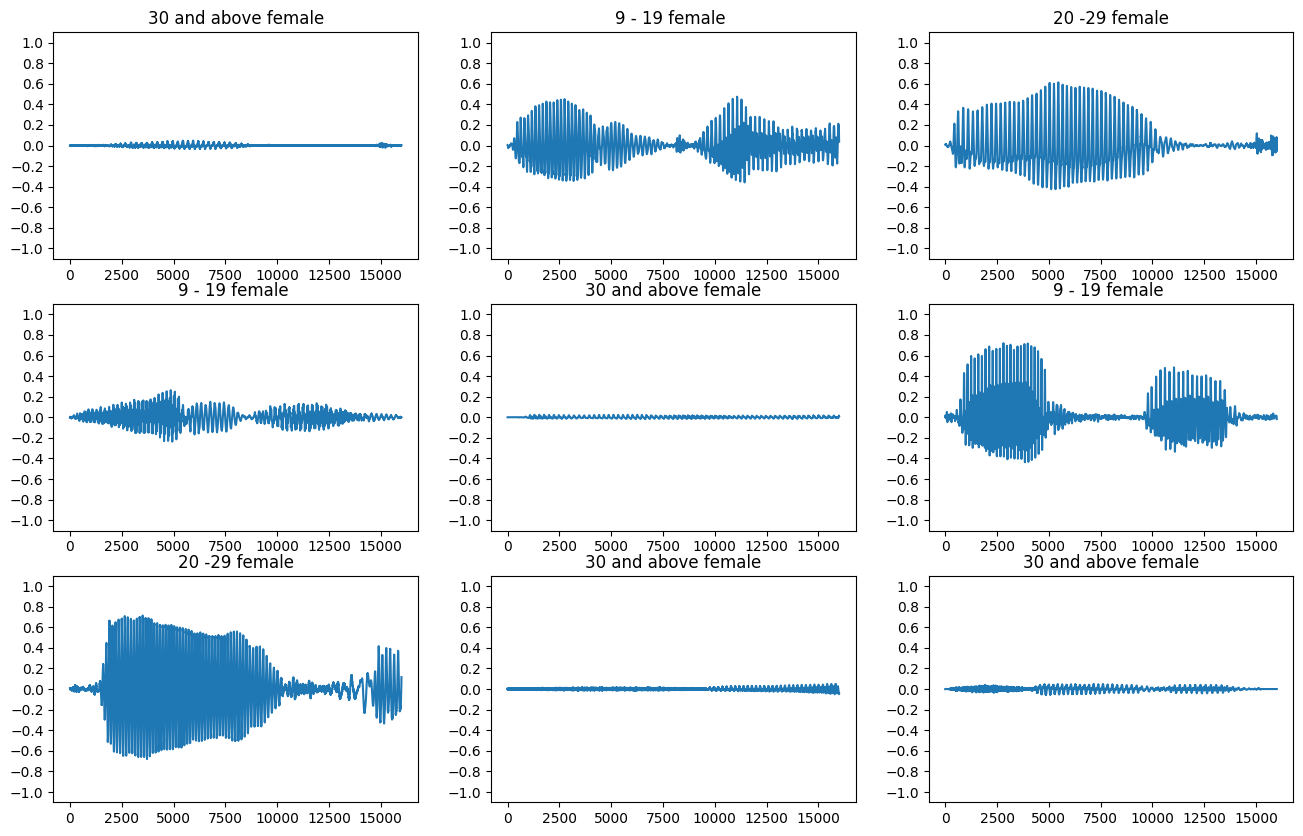

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=48000))

Label: 30 and above female
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: 9 - 19 female 
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: 20 -29 female
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


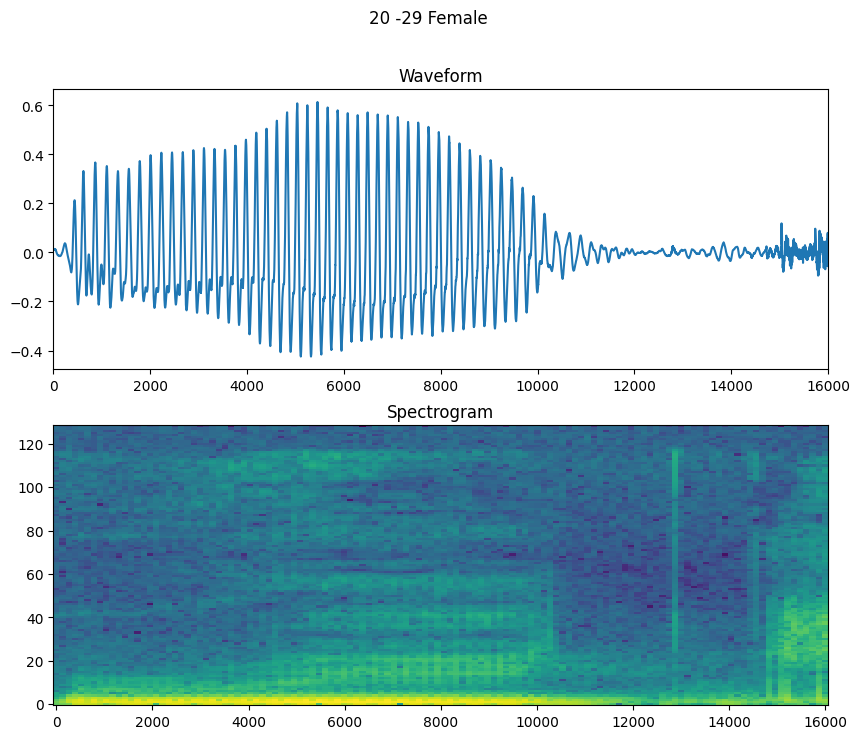

In [10]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [11]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


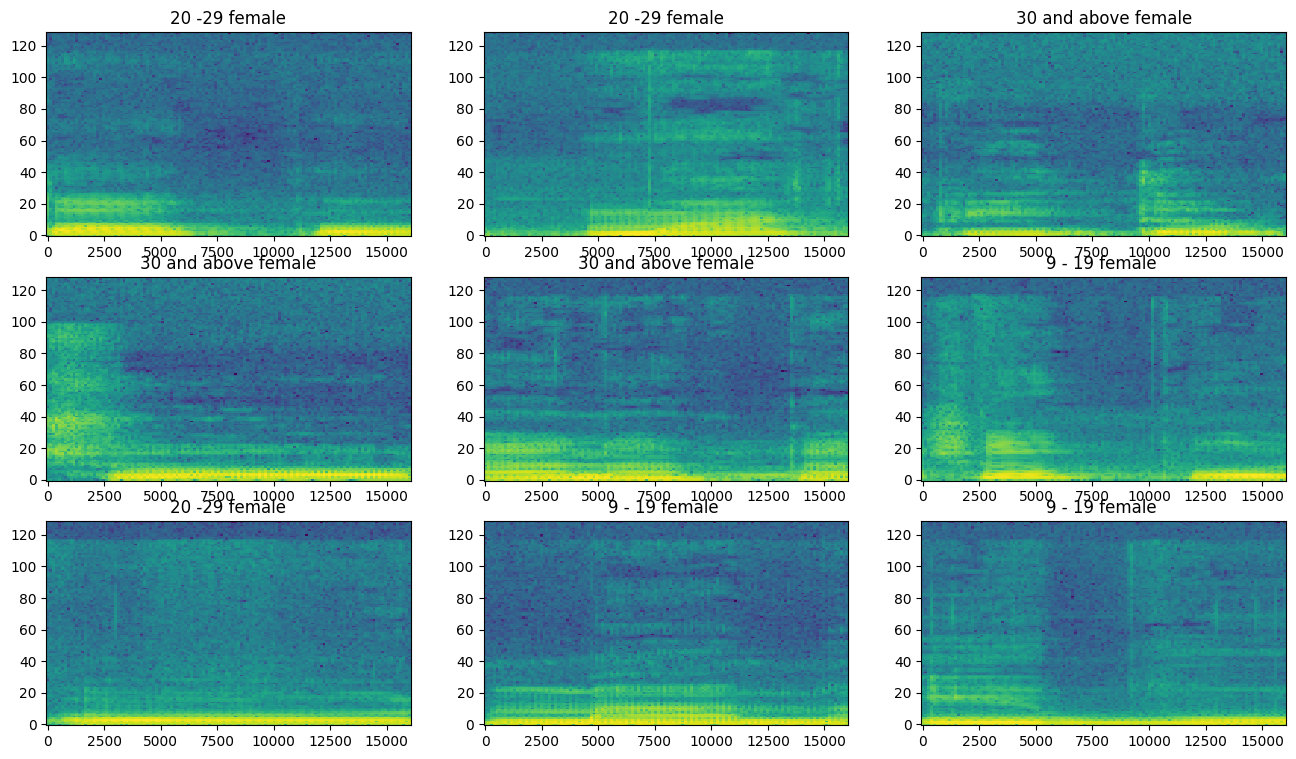

In [12]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [13]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(48, 48),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 48, 48, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 48, 48, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
34/34 [==============================] - 13s 328ms/step - loss: 0.7713 - accuracy: 0.6330 - val_loss: 0.6264 - val_accuracy: 0.6853
Epoch 2/10
34/34 [==============================] - 11s 313ms/step - loss: 0.5605 - accuracy: 0.7308 - val_loss: 0.5019 - val_accuracy: 0.7411
Epoch 3/10
34/34 [==============================] - 10s 286ms/step - loss: 0.4653 - accuracy: 0.7909 - val_loss: 0.3803 - val_accuracy: 0.8661
Epoch 4/10
34/34 [==============================] - 10s 287ms/step - loss: 0.3659 - accuracy: 0.8481 - val_loss: 0.2966 - val_accuracy: 0.8839
Epoch 5/10
34/34 [==============================] - 10s 287ms/step - loss: 0.3034 - accuracy: 0.8758 - val_loss: 0.2777 - val_accuracy: 0.9018
Epoch 6/10
34/34 [==============================] - 10s 308ms/step - loss: 0.2725 - accuracy: 0.8915 - val_loss: 0.3033 - val_accuracy: 0.8973
Epoch 7/10
34/34 [==============================] - 10s 286ms/step - loss: 0.2501 - accuracy: 0.9054 - val_loss: 0.2478 - val_accuracy: 0.8996

In [15]:
train_loss, train_accu = model.evaluate(train_spectrogram_ds)
val_loss, val_accu = model.evaluate(val_spectrogram_ds)
test_loss, test_accu = model.evaluate(test_spectrogram_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}, testing accuracy = {:.2f}".format(train_accu*100, val_accu*100, test_accu*100))

8/8 [==============================] - 1s 47ms/step - loss: 0.1903 - accuracy: 0.9332
final train accuracy = 97.00 , validation accuracy = 94.42, testing accuracy = 93.32


8/8 [==============================] - 0s 44ms/step


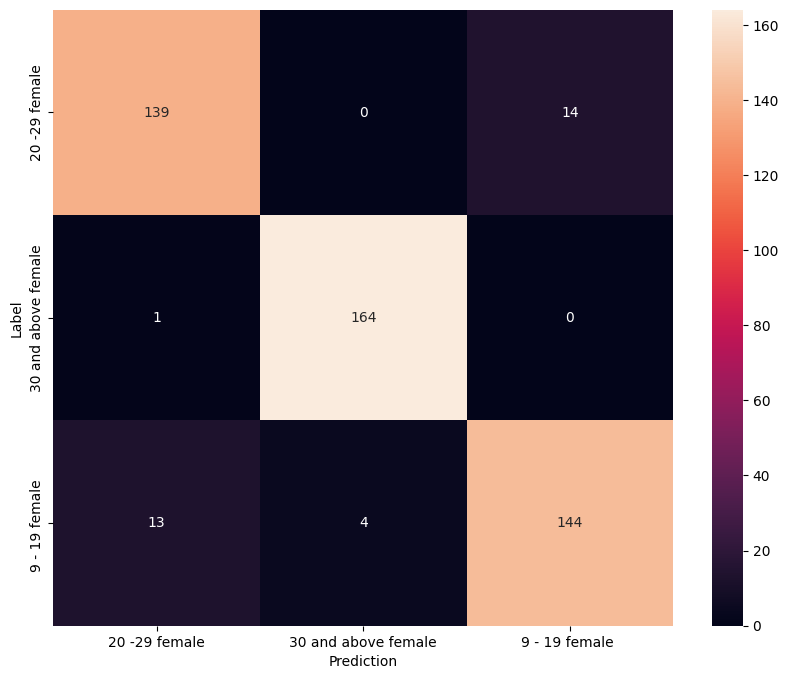

In [16]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [17]:
from sklearn.metrics import classification_report
import pprint
pprint.pprint(classification_report(y_true, y_pred, labels=[0,1,2,3]))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.91      0.91      0.91       153\n'
 '           1       0.98      0.99      0.98       165\n'
 '           2       0.91      0.89      0.90       161\n'
 '           3       0.00      0.00      0.00         0\n'
 '\n'
 '   micro avg       0.93      0.93      0.93       479\n'
 '   macro avg       0.70      0.70      0.70       479\n'
 'weighted avg       0.93      0.93      0.93       479\n')


/Users/msughter/projects/denv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/msughter/projects/denv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/msughter/projects/denv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/msughter

## where
* 0 represents 20 - 29 female
* 1 represents 30 and above female
* 2 represents 9 - 19 female

Text(0, 0.5, 'Accuracy [%]')

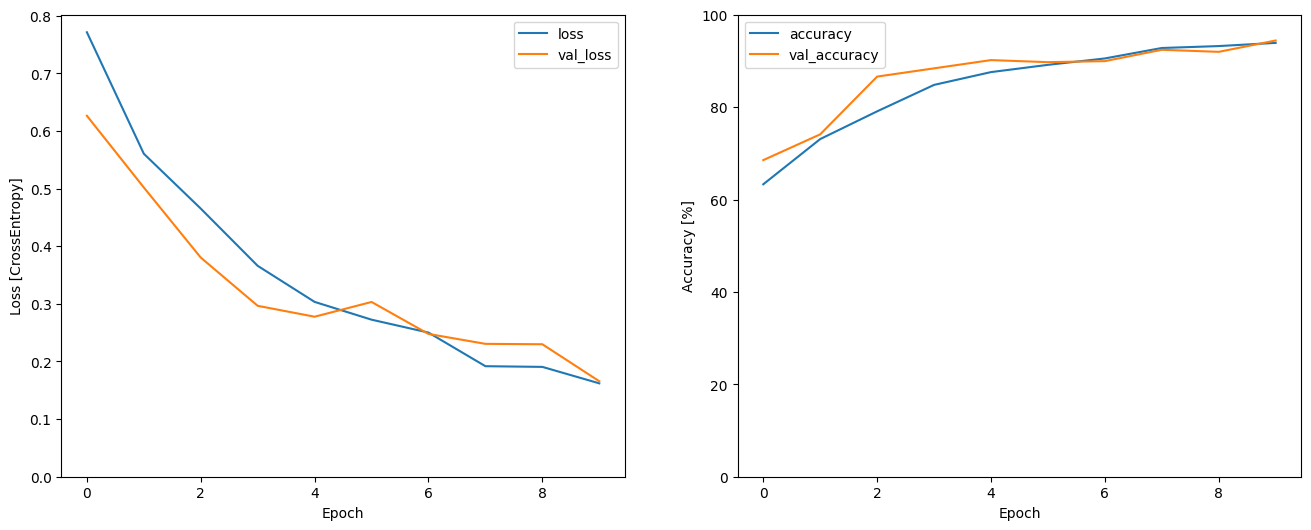

In [19]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [20]:
train_loss, train_accu = model.evaluate(train_spectrogram_ds)
val_loss, val_accu = model.evaluate(val_spectrogram_ds)
test_loss, test_accu = model.evaluate(test_spectrogram_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}, testing accuracy = {:.2f}".format(train_accu*100, val_accu*100, test_accu*100))

8/8 [==============================] - 0s 50ms/step - loss: 0.1903 - accuracy: 0.9332
final train accuracy = 97.00 , validation accuracy = 94.42, testing accuracy = 93.32


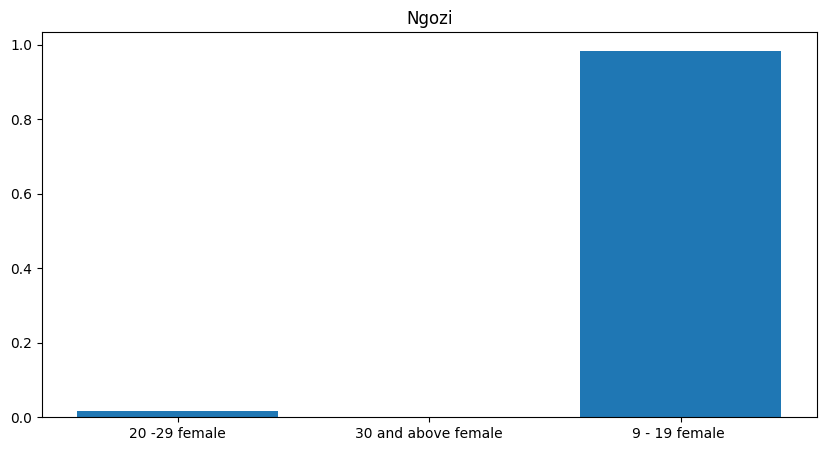

In [23]:
x = data_dir/'9 - 19 female /Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

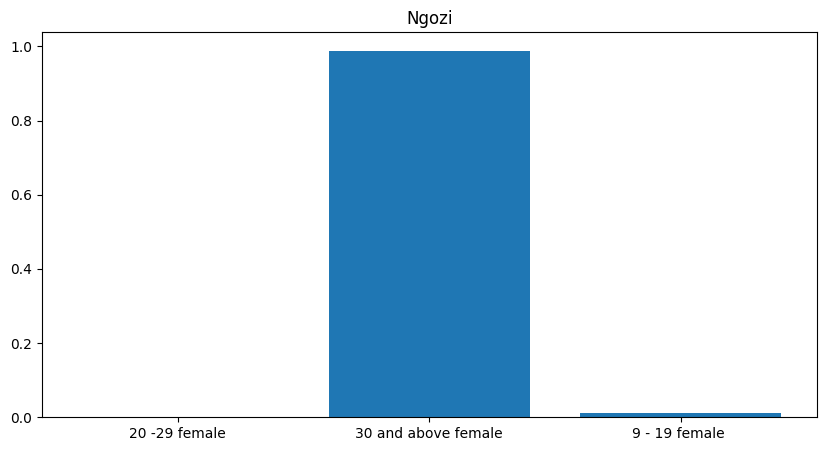

In [24]:
x = data_dir/'30 and above female/Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

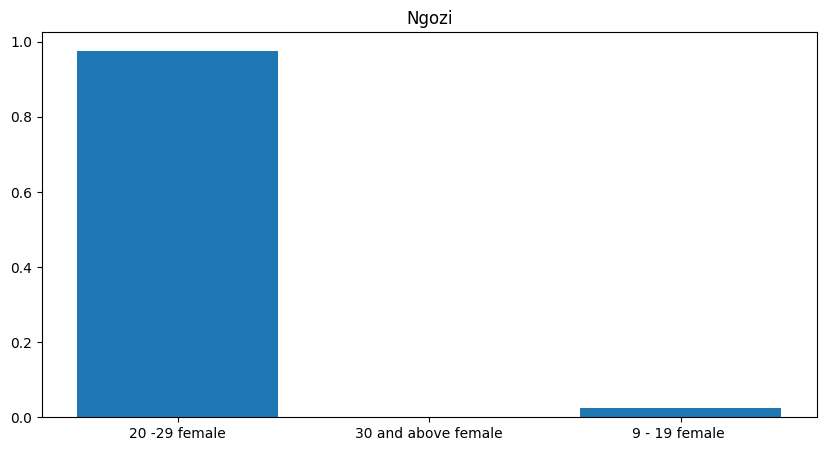

In [25]:
x = data_dir/'20 -29 female/Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [26]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Commands: ['20 -29 female' '9 - 19 female ' '30 and above female']


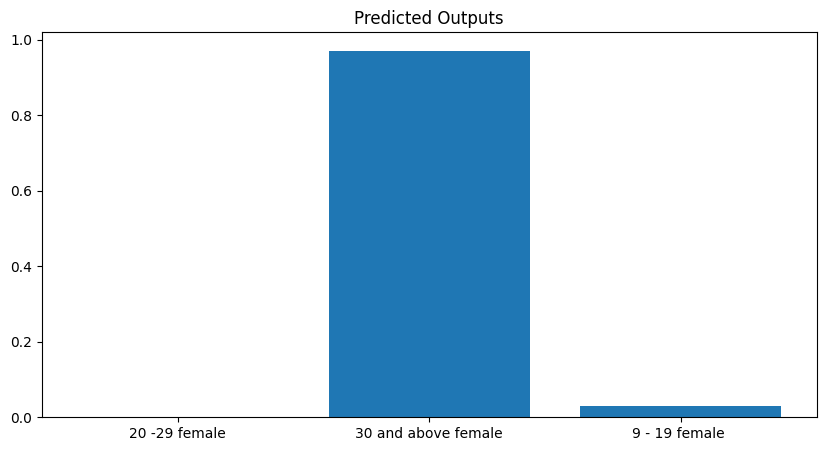

{'predictions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-3.9611971,  4.765451 ,  1.2481654]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'30 and above female'], dtype=object)>}

In [27]:
# *******************************************************************************************************************

#                                     PREDICTION OF NEW AUDIO FILE

# *******************************************************************************************************************


print('Commands:', commands)
predict = 'predict_audios/fortune2.wav'
x = predict
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicted Outputs')
plt.show()

export = ExportModel(model)
export(tf.constant(str(predict)))